In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.neural_network import MLPClassifier
import statsmodels.graphics.tsaplots as tsplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import stattools as stt
from statsmodels import tsa
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings

warnings.filterwarnings("ignore")

def is_stationary(df, maxlag=52, autolag=None, regression='c'):
    adf_test = stt.adfuller(df.values,maxlag=maxlag, autolag=autolag, regression=regression)
#     print(adf_test)
    adf = adf_test[0]
    cv_5 = adf_test[4]["5%"]
    result = adf < cv_5
#     print(adf, '--', cv_5, result)
    return result


def d_param(df, max_lag=52):
    d = 0
    if ~is_stationary(df):
        for i in range(1, max_lag):
            if is_stationary(df.diff(i).dropna()):
                d = i
                break;
    return d

def ARMA_params(df):
    p, q = tsa.stattools.arma_order_select_ic(np.asarray(df.dropna()),ic='aic').aic_min_order
    return p, q


# filePath = "Datasets/daily-min-temperatures.csv"
# filePath = "Datasets/daily-total-female-births.csv"
filePath = "Datasets/monthly-sunspots.csv"
# filePath = "Datasets/shampoo.csv"


csvFile = pd.read_csv(filePath)
print(csvFile)

        Month  Sunspots
0     1749-01      58.0
1     1749-02      62.6
2     1749-03      70.0
3     1749-04      55.7
4     1749-05      85.0
...       ...       ...
2815  1983-08      71.8
2816  1983-09      50.3
2817  1983-10      55.8
2818  1983-11      33.3
2819  1983-12      33.4

[2820 rows x 2 columns]


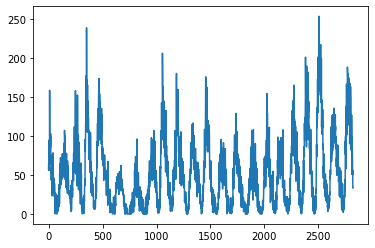

In [3]:
df1 = csvFile['Sunspots']
# df1 = csvFile['Value']
X = df1.values
plt.plot(X)

ADF Statistic: -7.076842
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
True


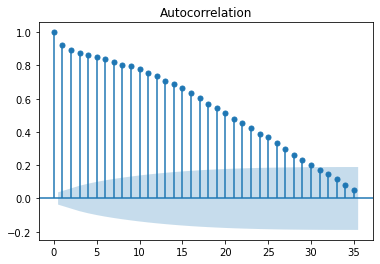

<Figure size 432x288 with 0 Axes>

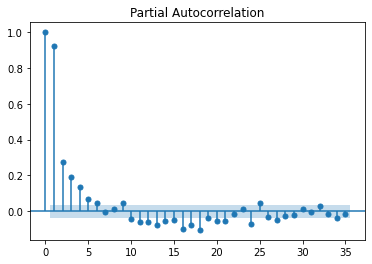

In [4]:
result = adfuller(df1, maxlag=52, autolag=None, regression='c')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

print(is_stationary(df1))
tsplot.plot_acf(X)
plt.figure()
tsplot.plot_pacf(X)    
plt.show()

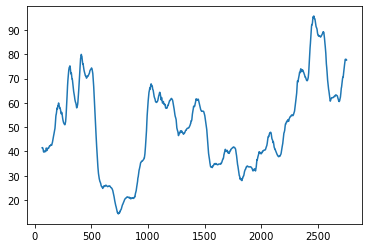

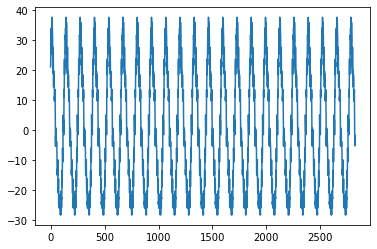

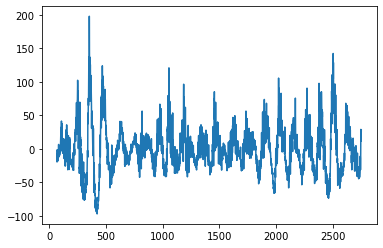

In [6]:
decomp = sm.tsa.seasonal_decompose(X, model='additive', period=132)
trend = decomp.trend
seas = decomp.seasonal
resid = decomp.resid
plt.plot(trend)
plt.figure()
plt.plot(seas)
plt.figure()
plt.plot(resid)
plt.show()
# trend = trend[~np.isnan(trend)]




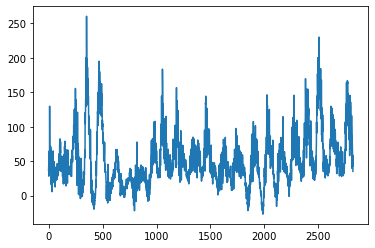

In [7]:
deseasonalized_series = X - seas
deseasonalized_series = deseasonalized_series[~np.isnan(deseasonalized_series)]
Y_deSd = pd.DataFrame(deseasonalized_series)
Y_deSd.dropna(inplace=True)
plt.plot(Y_deSd)

In [8]:
trainRatio = .99
thresh = int(Y_deSd.size*trainRatio)
print(thresh)
Y_deSd1 = Y_deSd[:thresh]
d = d_param(Y_deSd1)

res = sm.tsa.arma_order_select_ic(Y_deSd1, ic=["aic", "bic"], trend="c")
print(res.aic_min_order)
print(res.bic_min_order)
print(d)

2791
(3, 2)
(3, 2)
0


In [9]:

def evaluate_arima_model(X, arima_order, trainRatio):
    # prepare training dataset
    train_size = int(len(X)*trainRatio)
    train, test = X[:train_size], X[train_size:]

    history = [x for x in train]
    

    # make predictions
    predictions = []
    for i in range(0,len(test)):
        history1 = pd.DataFrame(np.asarray(history))

        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast(steps=1)[0]

        predictions.append(yhat)
        history.append(test[i])
        print(i,'/',len(test))
        
    mse_error = mean_squared_error(test, predictions)
    mape_error = mean_absolute_percentage_error(test, predictions)

    return mse_error, mape_error
print(d)
p = 3
d = 0
q = 2

arima_order = (p,d,q)
print(arima_order)
err = evaluate_arima_model(Y_deSd1.values, arima_order, trainRatio)
print(err)


0
(3, 0, 2)
0 / 28
1 / 28
2 / 28
3 / 28
4 / 28
5 / 28
6 / 28
7 / 28
8 / 28
9 / 28
10 / 28
11 / 28
12 / 28
13 / 28
14 / 28
15 / 28
16 / 28
17 / 28
18 / 28
19 / 28
20 / 28
21 / 28
22 / 28
23 / 28
24 / 28
25 / 28
26 / 28
27 / 28
(449.7448977484983, 0.1653425037710518)
